# CHURN PREDICTION MODEL

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm
import time

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import requests
from requests.exceptions import ReadTimeout, ConnectionError
import requests
import geopy
from geopy.geocoders import Nominatim
import time
import openmeteo_requests
import requests_cache
from retry_requests import retry

from pathlib import Path

import unimib_snowit_project.utils as u

# Load Datasets

In [2]:
root_dir_path = u.get_root_dir()
df_in_dir = "data_loaded"
data_pkl_dir_path = root_dir_path.joinpath(df_in_dir)


pkl_files = [
    'users.pkl',
    'profiles.pkl',
    'cards.pkl',
    'orders.pkl',
    'order_details.pkl',
]

pkl_paths = {file_name.split('.')[0]: data_pkl_dir_path.joinpath(file_name) for file_name in pkl_files}

dfs = {}

for name, path in pkl_paths.items():
    dfs[name] = pd.read_pickle(path)
    print(f"{name} loaded: {dfs[name].shape[0]} rows, {dfs[name].shape[1]} columns")


users_df = dfs['users']
profiles_df = dfs['profiles']
cards_df = dfs['cards']
orders_df = dfs['orders']   
order_details_df = dfs['order_details']

users loaded: 728598 rows, 14 columns
profiles loaded: 69025 rows, 10 columns
cards loaded: 184781 rows, 5 columns
orders loaded: 385168 rows, 13 columns
order_details loaded: 993037 rows, 15 columns


# Evaluate Churn Type

We have to identify customer churn, but we know that we may face different types of churn depending on the product's type:
- subscription business: the customer must pay a recurring price at regular 
intervals for the products or the services provided.
    
    E.g. monthly subscription to music platforms, energy  commodities provisioning,…
    
    →churn is clearly identifiable
 - non subscription business: the customer pays onceto own a product or for 
benefit a service.
    
    E.g.: purchasing baby clothes from a stores, request dental care operations from dentists, …
    
    →churn is not clearly identifiable

The first thing that we need to check if it's better to distinguish between subscription and non-subscription

In the order_details dataset:
- If product.durationHours or the difference between item.date and order date is >1 day, then probably is a subscription-like product.

- If product.durationHours is 1 day or null, then it's a non-subscription product.

In [3]:
order_details_df['item.date'] = pd.to_datetime(order_details_df['item.date'], errors='coerce')
order_details_df['product_duration_days'] = order_details_df['product.durationHours'].fillna(0) / 24

# identify subscription-like products
order_details_df['is_subscription_like'] = order_details_df['product_duration_days'] > 1
order_details_df['is_subscription_like'].value_counts()

is_subscription_like
False    993037
Name: count, dtype: Int64

The dataset doesn't contain any product that lasts more than one day, so we can assume that we are facing a non subcription business scenario.

## Visualize how Orders are distributed

In [4]:
orders_df['createdAt'] = pd.to_datetime(orders_df['createdAt'])

In [5]:
orders_df['y/m'] = orders_df['createdAt'].dt.to_period("M")

# evaluate the number of user active in each month of each year
monthly_counts = orders_df.groupby('y/m')['user.uid'].nunique().reset_index()
monthly_counts['y/m'] = monthly_counts['y/m'].astype(str)
monthly_counts

,y/m,user.uid
0,2022-07,458
1,2022-08,290
2,2022-09,70
3,2022-10,277
4,2022-11,2413
5,2022-12,18294
6,2023-01,23998
7,2023-02,20494
8,2023-03,10154
9,2023-04,1990


In [6]:
# line chart
fig = px.line(
    monthly_counts,
    x="y/m",
    y="user.uid",
    markers=True,
    title="Active Client by Month",
    labels={"y/m": "Month", "user.uid": "Number Active Clients"}
)

# high season
fig.add_vrect(
    x0="2022-11", x1="2023-03",
    fillcolor="orange", opacity=0.4,
    layer="below", line_width=0,
    annotation_text="High Season", annotation_position="top left"
)

fig.add_vrect(
    x0="2023-11", x1="2024-03",
    fillcolor="orange", opacity=0.4,
    layer="below", line_width=0,
    annotation_text="High Season", annotation_position="top left"
)

fig.add_vrect(
    x0="2024-11", x1="2025-02",
    fillcolor="orange", opacity=0.4,
    layer="below", line_width=0,
    annotation_text="High Season", annotation_position="top left"
)

# layout
fig.update_layout(
    xaxis_tickangle=-90,
    width=1000,
    height=500,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    xaxis = dict(
        type='category',    
        tickmode='array',      
        tickvals=monthly_counts['y/m'],     
        ticktext=monthly_counts['y/m'],
        tickfont=dict(size=14, family="Arial", color="black") 
    ),
    title=dict(
        font=dict(size=22, family="Arial", color="black")  
    ),
    yaxis=dict(
        tickfont=dict(size=14, family="Arial", color="black")  
    )
)

fig.show()


# Merge Orders with Order_Details

In [7]:
order_agg_all = order_details_df.groupby('order.uid').agg(
    total_amount=('item.amount', 'sum'),
    last_item_date=('item.date', 'max'),
    max_duration_hours=('product.durationHours', 'max'),

    # Behavioural info
    total_items=('item.uid', 'count'),
    completed_items=('item.status', lambda x: sum(x.isin(['ok', 'fulfilled']))),
    cancelled_items=('item.status', lambda x: sum(x == 'cancelled')),
    onhold_items=('item.status', lambda x: sum(x == 'on-hold')),
    processing_items=('item.status', lambda x: sum(x.isin(['transfer', 'processing']))),

    # Discount info
    discount_items=('item.discount', lambda x: sum(x == True)),
    dynamic_pricing_items=('product.dynamicPricing', lambda x: sum(x == True)),

    # Product diversity
    unique_products=('product.uid', 'nunique'),
    unique_product_types=('product.type', 'nunique'),
    unique_zones=('item.zoneName', 'nunique'),
).reset_index()

In [8]:
# Compute behavioral rates

order_agg_all['completion_rate'] = order_agg_all['completed_items'] / order_agg_all['total_items']
order_agg_all['cancellation_rate'] = order_agg_all['cancelled_items'] / order_agg_all['total_items']
order_agg_all['onhold_rate'] = order_agg_all['onhold_items'] / order_agg_all['total_items']
order_agg_all['discount_rate'] = order_agg_all['discount_items'] / order_agg_all['total_items']
order_agg_all['dynamic_rate'] = order_agg_all['dynamic_pricing_items'] / order_agg_all['total_items']

In [9]:
# compute total price (per order) for each category (grouped to avoid having a lot of null values)

category_map = {
     'skipass': [
        'skipass', 'skipass~dynamic', 'skipass~hotel',
        'skipass~membership', 'skipass~membership-seasonal',
        'skipass~return', 'voucher~skipass', 'seasonal'
    ],
    'bundle': [
        'bundle', 'bundle~dynamic', 'bundle~tab',
        'bundle~train', 'bundle~travel'
    ],
    'hotel': ['hotel', 'hotel~coupon'],
    'transport': ['transport', 'transport~ferry'],
    'rental': ['rental', 'rental~bike'],
    'experience': ['experience', 'experience~museum', 'lesson', 'itinerary'],
    'services': ['service', 'parking', 'insurance'],
    'gift_promo': ['giftcard', 'coupon', 'snowitcard'],
    'food': ['food']
}

flat_map = {cat: macro
            for macro, cats in category_map.items()
            for cat in cats}

order_details_df['macro_category'] = (
    order_details_df['product.type']
    .map(flat_map)
    .fillna('other')
)
macro_totals = (
    order_details_df
        .groupby(['order.uid', 'macro_category'])['item.amount']
        .sum()
        .reset_index()
)

# wide format to have one row for each order.uid
macro_wide = (
    macro_totals
        .pivot(index='order.uid',
               columns='macro_category',
               values='item.amount')
        .fillna(0)
        .add_suffix('_spent')
        .reset_index()
)

#add the columns to order_agg_all dataset
order_agg_all = (
    order_agg_all
        .merge(macro_wide,
               on='order.uid',    
               how='left')
)

In [10]:
#merge with orders_df
full_orders = orders_df.merge(order_agg_all, on='order.uid', how='left')

# remove non essential columns
full_orders = full_orders.drop(columns=['completed_items','cancelled_items','onhold_items','processing_items','discount_items','dynamic_pricing_items',
                                        'createdAtTime'])

In [11]:
full_orders.head()

,order.uid,user.uid,createdAt,paymentGateway,paymentBrand,pickup,pickupComplete,source,tenant,paymentAttempts,...,dynamic_rate,bundle_spent,experience_spent,food_spent,gift_promo_spent,hotel_spent,rental_spent,services_spent,skipass_spent,transport_spent
0,4y9zqqvldfqr9n2xnu,nu7fhz41rzwbkabapcufr6g18r,2024-07-01,stripe,visa,False,False,website,snowit_esterno,2,...,0.0,0.0,0.0,0.0,0.0,0.0,59.5,0.0,0.0,0.0
1,i9eovtgp3uxbmesebv,hkxsbgefntzwsodvj3ztvp3gm1,2024-07-01,discount,none,False,False,website,discovera,1,...,0.0,50.0,30.0,0.0,0.0,0.0,0.0,5.0,0.0,15.0
2,nsc55zfspubshggcm5,hkxsbgefntzwsodvj3ztvp3gm1,2024-07-01,discount,none,False,False,website,discovera,1,...,0.0,32.400002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.400002
3,ltr5f48gwicqwcnzkf,hkxsbgefntzwsodvj3ztvp3gm1,2024-07-01,discount,none,False,False,website,discovera,1,...,0.0,27.700001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.700001
4,gxaalzomhfvvdlaxiz,j7dlvmya0aazq8muvzafu1ezmo,2024-07-01,stripe,mastercard,False,False,website,snowit_esterno,2,...,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0


In [12]:
full_orders.columns

Index(['order.uid', 'user.uid', 'createdAt', 'paymentGateway', 'paymentBrand',
       'pickup', 'pickupComplete', 'source', 'tenant', 'paymentAttempts',
       'timeZone', 'clientInfo', 'y/m', 'total_amount', 'last_item_date',
       'max_duration_hours', 'total_items', 'unique_products',
       'unique_product_types', 'unique_zones', 'completion_rate',
       'cancellation_rate', 'onhold_rate', 'discount_rate', 'dynamic_rate',
       'bundle_spent', 'experience_spent', 'food_spent', 'gift_promo_spent',
       'hotel_spent', 'rental_spent', 'services_spent', 'skipass_spent',
       'transport_spent'],
      dtype='object')

 ## Snow data

In [13]:
# we have a lot of different locations
order_details_df['item.zoneName'].unique()

array(['Bormio', 'Desenzano del Garda', 'Lago Maggiore', 'Lago di Como',
       '<NA>', "Lago d'Iseo", 'Barzio - Piani di Bobbio', 'Tanzania',
       'Cervinia', 'Italia', 'Germania', 'Pontedilegno-Tonale',
       "Lecco - Piani d'Erna", 'Lago di Garda', 'Bardonecchia', 'Spagna',
       'Grecia', 'Livigno', 'Marocco', 'Egitto', 'Brasile', 'La Thuile',
       'Pila', 'Sestriere - Vialattea', 'Folgaria',
       'Madonna di Campiglio', 'Monginevro', 'Santa Caterina Valfurva',
       'Capo Verde', 'Folgarida - Marilleva', 'Madesimo', 'Pinzolo',
       'Cimone', 'Francia', 'Monte Bondone', 'Andalo', 'Corno alle Scale',
       'Champoluc - Monterosa Ski', 'Aprica',
       'Chiesa Valmalenco Bernina Ski Resort', 'Tunisia',
       "Lago d'Iseo e Franciacorta", 'Badia - Alta Badia',
       'Aereoporto Malpensa', 'Courmayeur',
       'Gressoney-La-Trinité - Monterosa Ski', 'Lombardia',
       'Alagna - Monterosa Ski', 'Norvegia', 'Alpe di Siusi', 'Wengen',
       'Foppolo', 'Pejo', 'Ortisei - Va

In [14]:
# solve missing area
solve_na = {
    'Pontedilegno-Tonale':'Passo del Tonale',
    'Chiesa Valmalenco Bernina Ski Resort': 'Chiesa in Valmalenco',
    'Valmalenco Bernina Ski Resort': 'Chiesa in Valmalenco',
    "Lago d'Iseo e Franciacorta": "Lago d'Iseo",
    'Aereoporto Malpensa': 'Malpensa',
    'Sansicario - Vialattea': 'Sansicario',
    'Falcade - Alpe Lusia': 'Alpe Lusia',
    'La Villa - Alta Badia': 'Alta Badia',
    'Claviere - Vialattea': 'Claviere',
    'Monginevro - Vialattea': 'Monginevro'
}

In [15]:
order_details_df['item.zoneName'] = order_details_df['item.zoneName'].apply(lambda z: solve_na.get(z, z))

In [16]:
zone_to_macro = {
    # Alpi Nord-Ovest (Piemonte and Valle d’Aosta)
    'Alagna': 'Alpi Nord-Ovest',
    'Alagna - Monterosa Ski': 'Alpi Nord-Ovest',
    'Champoluc': 'Alpi Nord-Ovest',
    'Champoluc - Monterosa Ski': 'Alpi Nord-Ovest',
    'Cervinia': 'Alpi Nord-Ovest',
    'Bardonecchia': 'Alpi Nord-Ovest',
    'Limone Piemonte': 'Alpi Nord-Ovest',
    'Gressoney-La-Trinité': 'Alpi Nord-Ovest',
    'Gressoney-La-Trinité - Monterosa Ski': 'Alpi Nord-Ovest',
    'La Thuile': 'Alpi Nord-Ovest',
    'Pré-Saint-Didier': 'Alpi Nord-Ovest',

    # Alpi Nord-Est (Trentino-Alto Adige / Veneto)
    'Madonna di Campiglio': 'Alpi Nord-Est',
    'Madonna di Campiglio e Pinzolo': 'Alpi Nord-Est',
    'Ortisei': 'Alpi Nord-Est',
    'Ortisei - Val Gardena': 'Alpi Nord-Est',
    'Valdaora': 'Alpi Nord-Est',
    'Valdaora - Plan de Corones': 'Alpi Nord-Est',
    'San Martino di Castrozza': 'Alpi Nord-Est',
    'Fai della Paganella': 'Alpi Nord-Est',
    'Folgaria': 'Alpi Nord-Est',
    'Pejo': 'Alpi Nord-Est',
    'Pila': 'Alpi Nord-Est',
    'Canazei': 'Alpi Nord-Est',
    'Canazei - Val di Fassa': 'Alpi Nord-Est',
    'Campitello di Fassa': 'Alpi Nord-Est',
    'Pozza di Fassa': 'Alpi Nord-Est',
    'Alpe di Siusi': 'Alpi Nord-Est',
    'San Bernardino': 'Alpi Nord-Est',
    'Selva di Val Gardena': 'Alpi Nord-Est',
    'Santa Cristina - Val Gardena': 'Alpi Nord-Est',
    'Santa Cristina': 'Alpi Nord-Est',
    'Sappada': 'Alpi Nord-Est',
    'Dobbiaco': 'Alpi Nord-Est',
    'Dobbiaco - 3 Cime': 'Alpi Nord-Est',
    'Brunico': 'Alpi Nord-Est',
    'Brunico - Plan de Corones': 'Alpi Nord-Est',
    'Badia': 'Alpi Nord-Est',
    'Badia - Alta Badia': 'Alpi Nord-Est',
    'Colfosco': 'Alpi Nord-Est',
    'Colfosco - Alta Badia': 'Alpi Nord-Est',
    'Corvara': 'Alpi Nord-Est',
    'Corvara - Alta Badia': 'Alpi Nord-Est',
    'La Villa - Alta Badia': 'Alpi Nord-Est',
    'Alleghe': 'Alpi Nord-Est',
    'Alleghe - Civetta': 'Alpi Nord-Est',
    'Arabba': 'Alpi Nord-Est',
    'Falcade': 'Alpi Nord-Est',
    'Falcade - Alpe Lusia': 'Alpi Nord-Est',
    "Cortina d'Ampezzo": 'Alpi Nord-Est',
    'Zoncolan': 'Alpi Nord-Est',
    'Folgarida - Marilleva': 'Alpi Nord-Est',
    'Pinzolo': 'Alpi Nord-Est',
    'Garda Trentino': 'Alpi Nord-Est',
    'Sella Nevea - Kanin': 'Alpi Nord-Est',
    

    # Alpi Lombardia
    'Bormio': 'Alpi Lombardia',
    'Livigno': 'Alpi Lombardia',
    'Madesimo': 'Alpi Lombardia',
    'Pontedilegno-Tonale': 'Alpi Lombardia',
    'Prato Nevoso': 'Alpi Lombardia',
    'Presolana': 'Alpi Lombardia',
    'Montecampione': 'Alpi Lombardia',
    'Monte Pora': 'Alpi Lombardia',
    'Monte Bondone': 'Alpi Lombardia',
    'Monginevro': 'Alpi Lombardia',
    'Valtorta - Piani di Bobbio': 'Alpi Lombardia',
    'Barzio': 'Alpi Lombardia',
    'Barzio - Piani di Bobbio': 'Alpi Lombardia',
    'Aprica': 'Alpi Lombardia',
    'Colere': 'Alpi Lombardia',
    'Andalo': 'Alpi Lombardia',
    'Chiesa Valmalenco Bernina Ski Resort': 'Alpi Lombardia',
    'Valmalenco Bernina Ski Resort': 'Alpi Lombardia', 
    'Cima Piazzi - San Colombano': 'Alpi Lombardia',
    'Foppolo': 'Alpi Lombardia',
    'Moggio - Artavaggio': 'Alpi Lombardia',

    # Appennini
    'Corno alle Scale': 'Appennini',
    'Cimone': 'Appennini',
    'Ovindoli': 'Appennini',
    'Campo Felice': 'Appennini',
    'Roccaraso': 'Appennini',
    'Camigliatello Silano': 'Appennini',
    'Abruzzo': 'Appennini',
    "Val d'Orcia": 'Appennini',

    # Laghi
    'Lago Maggiore': 'Laghi',
    'Lago di Como': 'Laghi',
    'Lago di Garda': 'Laghi',
    "Desenzano del Garda": 'Laghi',
    "Lago d'Iseo": 'Laghi',
    "Lago d'Iseo e Franciacorta": 'Laghi',
    'Lago di Lugano': 'Laghi',
    'Lago di Varese': 'Laghi',
    "Lecco - Piani d'Erna": 'Laghi',

    # Città / pianura
    'Milano': 'Città / Pianura',
    'Monza': 'Città / Pianura',
    'Pavia': 'Città / Pianura',
    'Assisi': 'Città / Pianura',
    'San Pellegrino Terme': 'Città / Pianura',
    'Riviera Ligure': 'Città / Pianura',

    # Estero / grandi resort
    'Austria': 'Estero',
    'Germania': 'Estero', 
    'Kitzbühel': 'Estero',
    'St. Anton': 'Estero',
    'Schladming': 'Estero',
    'Schärding': 'Estero',
    'Francia': 'Estero',
    'Les Deux Alpes': 'Estero',
    'Courchevel': 'Estero',
    'Islanda': 'Estero',
    'Irlanda': 'Estero',
    'Spagna': 'Estero',
    'St. Moritz': 'Estero',
    'Wengen': 'Estero',
    'Marocco': 'Estero',
    'Mauritius': 'Estero',
    'Brasile': 'Estero',
    'Tanzania': 'Estero',
    'Tunisia': 'Estero',
    'Egitto': 'Estero',
    'Norvegia': 'Estero',
    "Alpe d'Huez": 'Estero',
    'Grecia': 'Estero',
    'Capo Verde': 'Estero',

    # Resort / brand / aeroporti
    'Aereoporto Malpensa': 'Resort / Trasporti',
    'Snowit': 'Resort / Trasporti',
    'Skyway Monte Bianco - Courmayeur': 'Resort / Trasporti',
    'Claviere - Vialattea': 'Resort',
    'Monginevro - Vialattea': 'Resort',
    'Sestriere - Vialattea': 'Resort',
    "Sauze D'Oulx - Vialattea": 'Resort',
    'Courmayeur': 'Resort',
    'Domobianca': 'Resort',
    'Santa Caterina Valfurva': 'Resort',
    'La Thuile': 'Resort',
    'Torgnon': 'Resort',
    'Valtournenche': 'Resort',
    'Sansicario - Vialattea': 'Resort', 
    'Sestriere': 'Resort',

    # Macro-regioni italiane generiche / fallback
    'Italia': 'Italia',
    'Lombardia': 'Italia',
    'Piemonte': 'Italia',
    'Trentino-Alto Adige': 'Italia',
    'Liguria': 'Italia',
    'Sardegna': 'Italia',
    'Sicilia': 'Italia',
    'Veneto': 'Italia'
}


In [17]:
# group each order's locations
zone_per_order = (
    order_details_df[order_details_df['item.zoneName'] != '<NA>']
    .groupby('order.uid')
    .agg(zones=('item.zoneName', lambda x: sorted(set(x))))
    .reset_index()
)

In [18]:
zone_per_order['zones'].value_counts()

zones
[Passo del Tonale]                      58546
[Barzio - Piani di Bobbio]              52852
[Bormio]                                43513
[Aprica]                                22214
[Chiesa in Valmalenco]                  17498
                                        ...  
[Alagna - Monterosa Ski, Monte Pora]        1
[Bormio, Chiesa in Valmalenco]              1
[Aprica, Valtorta - Piani di Bobbio]        1
[Folgaria, Passo del Tonale]                1
[Livigno, Madesimo]                         1
Name: count, Length: 257, dtype: int64

In [19]:
# add zones to full_orders
full_orders = full_orders.merge(zone_per_order, how='left', on ='order.uid')

# Repurchase Curve

In [20]:
full_orders['createdAt'] = pd.to_datetime(full_orders['createdAt'])
full_orders = full_orders.sort_values(['user.uid','createdAt'])

In [21]:
order_intervals = full_orders.groupby('user.uid')['createdAt'].apply(lambda s: s.diff().dt.days).explode().dropna()
repurchase_80 = int(np.percentile(order_intervals, 80))
repurchase_90 = int(np.percentile(order_intervals, 90))
print("Repurchase 80%:", repurchase_80, "days")
print("Repurchase 90%:", repurchase_90, "days")

# visualization
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=order_intervals,
    nbinsx=50,  
    name="Intervals between orders",
    marker_color='steelblue'
))

# percentile 80
fig.add_vline(
    x=repurchase_80,
    line=dict(color='orange', width=3, dash='dash'),
    annotation_text=f"80° percentile ({repurchase_80} days)",
    annotation_position="top right"
)

# percentile 90
fig.add_vline(
    x=repurchase_90,
    line=dict(color='red', width=3, dash='dash'),
    annotation_text=f"90° percentile ({repurchase_90} days)",
    annotation_position="top right"
)

# Layout generale
fig.update_layout(
    title="Distribution of intervals between Orders",
    xaxis_title="Days between Orders",
    yaxis_title="Occurrences",
    width=900,
    height=500,
    bargap=0.2
)

fig.show()

Repurchase 80%: 83 days
Repurchase 90%: 330 days


the majority of the clients repurchases in a relatively short time (83 days), however there's a part of the customer base that repurchase only in the following season (90% = 330, almost an year later).

# Churn Analysis

### Preliminary work

In [22]:
# function to define high seasonality months
def is_peak(month):
    return month in [11,12,1,2,3]

In [23]:
# variable regarding the month in which the order has been created
full_orders['month'] = full_orders['createdAt'].dt.month
peak_orders = full_orders[full_orders['month'].apply(is_peak)]

print(full_orders.shape)
print(peak_orders.shape)

# the majority of the purchases is made during the peak season.

(385168, 36)
(372517, 36)


### Reference dates Choice

These dates has been chosen considering the "Number of Orders per Month" graph of the EDA, trying to split in half the distributions of orders

In [24]:
# Reference dates are chosen to capture key moments within the ski season, considering the strong seasonality of the business. 

# We selected them right in the middle of the seasons to identify customers at risk of churn 
# within the season itself

reference_dates = pd.to_datetime([ '2023-02-15','2024-02-15', '2025-02-01'])

def get_lookback(ref_date):
    if (ref_date.month) == 2: 
        return 90 # to the begin of the current season

def get_outcome(ref_date):
    if (ref_date.month) == 2:
        return 120 # to the end of the current season

### Dataset Building

In [25]:
full_orders.reset_index(inplace=True)

In [26]:
full_orders = full_orders.sort_values('createdAt').set_index('createdAt')

snapshots = []
churn_summary = []

for ref in reference_dates:
    look_back_days = get_lookback(ref)
    outcome_days   = get_outcome(ref)

    lb_start   = max(ref - pd.Timedelta(days=look_back_days), full_orders.index.min())
    outcome_end = min(ref + pd.Timedelta(days=outcome_days), full_orders.index.max())
    
    # datasets in look-back and holdout
    orders_lb     = full_orders.loc[lb_start:ref]
    future_orders = full_orders.loc[ref:outcome_end]
    
    # active clients in lookback
    active_uids = orders_lb['user.uid'].unique()
    if len(active_uids) == 0:
        continue
    
    # feature aggregate per user in look-back period
    user_feat = orders_lb.groupby('user.uid').agg({
        'order.uid': 'nunique',
        'total_amount':'sum',
        'completion_rate':'mean',
        'cancellation_rate':'mean',
        'onhold_rate':'mean',
        'discount_rate':'mean',
        'dynamic_rate':'mean',
        'pickup':['any','mean'],
        'pickupComplete':'mean',
        'paymentAttempts':['mean','max']
    })
    user_feat.columns = ['_'.join(col).strip() for col in user_feat.columns.values]
    user_feat = user_feat.reset_index()
    
    # normalized preferences
    for col in ['paymentGateway','paymentBrand','source','tenant']:
        filtered = orders_lb[orders_lb[col] != 'none']

        counts = (orders_lb.groupby('user.uid')[col]
                  .value_counts(normalize=True)
                  .unstack(fill_value=0)
                  .reindex(columns=[c for c in filtered[col].unique() if c != 'none'], fill_value=0)
                  .add_prefix(f"{col}_")
                  .reset_index())
        user_feat = user_feat.merge(counts, on='user.uid', how='left')
    
    #zones
    user_zones = (
        orders_lb[orders_lb['zones'].notna()]
        .groupby('user.uid')['zones']
        .apply(lambda lists: sorted(set([zone for sublist in lists for zone in sublist])))
        .reset_index()
    )
    user_feat = user_feat.merge(user_zones, on='user.uid', how='left')
    
    # macro categories
    macro_cols = [c for c in orders_lb.columns if c.endswith('_spent')]
    macro_sum = orders_lb.groupby('user.uid')[macro_cols].sum().reset_index()
    user_feat = user_feat.merge(macro_sum, on='user.uid', how='left')
    
    # time categories
    user_feat['prediction_date'] = ref

    # label as churn clients not in future_uids
    future_uids = future_orders['user.uid'].unique()
    user_feat['churn'] = (~user_feat['user.uid'].isin(future_uids)).astype(int)
    
    # churn summary
    churn_flags = user_feat['churn']
    n_churn = churn_flags.sum()
    n_active = len(churn_flags) - n_churn
    
    churn_summary.append({
        'reference_date': ref,
        'n_active_users': n_active,
        'n_churn_users': n_churn,
        'churn_rate': n_churn / len(churn_flags)
    })

    churn_summary_df = pd.DataFrame(churn_summary)
    
    # append
    snapshots.append(user_feat)

snapshots = pd.concat(snapshots, ignore_index=True)
print("Dataset snapshot churn ready:", snapshots.shape)

Dataset snapshot churn ready: (167288, 48)


In [27]:
churn_summary

[{'reference_date': Timestamp('2023-02-15 00:00:00'),
  'n_active_users': np.int64(8754),
  'n_churn_users': np.int64(36940),
  'churn_rate': np.float64(0.808421236923885)},
 {'reference_date': Timestamp('2024-02-15 00:00:00'),
  'n_active_users': np.int64(11942),
  'n_churn_users': np.int64(44604),
  'churn_rate': np.float64(0.7888091111661303)},
 {'reference_date': Timestamp('2025-02-01 00:00:00'),
  'n_active_users': np.int64(8785),
  'n_churn_users': np.int64(56263),
  'churn_rate': np.float64(0.864945886114869)}]

In [28]:
# to df
df_churn = pd.DataFrame(churn_summary)

# figure
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_churn['reference_date'],
    y=df_churn['n_active_users'],
    name='Active Users',
    marker_color='green',
    yaxis='y1'
))

fig.add_trace(go.Bar(
    x=df_churn['reference_date'],
    y=df_churn['n_churn_users'],
    name='Churn Users',
    marker_color='red',
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=df_churn['reference_date'],
    y=df_churn['churn_rate'],
    name='Churn Rate',
    mode='lines+markers',
    marker=dict(size=10, color='blue'),
    yaxis='y2'
))

fig.update_layout(
    title="Churn Summary",
    xaxis=dict(title="Reference Date"),
    yaxis=dict(title="Number of Users", side="left"),
    yaxis2=dict(title="Churn Rate", overlaying="y", side="right", tickformat=".0%"),
    barmode='group',
    legend=dict(x=0.01, y=0.99, bordercolor="Black", borderwidth=1)
)

fig.show()

### Add weather information

In [29]:
zones = (order_details_df['item.zoneName'].unique())
zones = zones[zones != '<NA>']
zones

array(['Bormio', 'Desenzano del Garda', 'Lago Maggiore', 'Lago di Como',
       "Lago d'Iseo", 'Barzio - Piani di Bobbio', 'Tanzania', 'Cervinia',
       'Italia', 'Germania', 'Passo del Tonale', "Lecco - Piani d'Erna",
       'Lago di Garda', 'Bardonecchia', 'Spagna', 'Grecia', 'Livigno',
       'Marocco', 'Egitto', 'Brasile', 'La Thuile', 'Pila',
       'Sestriere - Vialattea', 'Folgaria', 'Madonna di Campiglio',
       'Monginevro', 'Santa Caterina Valfurva', 'Capo Verde',
       'Folgarida - Marilleva', 'Madesimo', 'Pinzolo', 'Cimone',
       'Francia', 'Monte Bondone', 'Andalo', 'Corno alle Scale',
       'Champoluc - Monterosa Ski', 'Aprica', 'Chiesa in Valmalenco',
       'Tunisia', 'Badia - Alta Badia', 'Malpensa', 'Courmayeur',
       'Gressoney-La-Trinité - Monterosa Ski', 'Lombardia',
       'Alagna - Monterosa Ski', 'Norvegia', 'Alpe di Siusi', 'Wengen',
       'Foppolo', 'Pejo', 'Ortisei - Val Gardena',
       "Sauze D'Oulx - Vialattea", 'Ovindoli', 'Pozza di Fassa',
     

In [30]:
geolocator = Nominatim(user_agent="snowit_project")

results = []

for zone in zones:
    try:
        # look for the zone
        location = geolocator.geocode(zone)
        if location:
            results.append({'zone': zone, 'lat': location.latitude, 'lon': location.longitude})
        else:
            results.append({'zone': zone, 'lat': None, 'lon': None})
    except Exception as e:
        print(f"Errore per {zone}: {e}")
        results.append({'zone': zone, 'lat': None, 'lon': None})
    
    time.sleep(1)

# to df
zones_coord_df = pd.DataFrame(results)

In [31]:
zones_coord_df = zones_coord_df.dropna()

In [32]:
zones_coord_df

,zone,lat,lon
0,Bormio,46.469248,10.372171
1,Desenzano del Garda,45.469485,10.538947
2,Lago Maggiore,45.951094,8.634165
3,Lago di Como,45.991759,9.264881
4,Lago d'Iseo,45.738878,10.070866
...,...,...,...
135,Dobbiaco,46.735425,12.224280
136,Corvara,46.549574,11.874034
137,Sestriere,44.958453,6.878685
138,Moggio - Artavaggio,45.931383,9.507782


In [33]:
# get aggregate features on lookback period

def extract_period_features(daily_df, ref_date, lookback_days):
    period_df = daily_df[(daily_df['date'] > ref_date - pd.Timedelta(days=lookback_days)) &
                         (daily_df['date'] <= ref_date)]
    if period_df.empty:
        return {'snowfall_sum': 0, 'snow_depth_max': 0, 'temp_mean_avg': None, 'days_no_snow': 0}
    
    return {
        'snowfall_sum': period_df['snowfall'].sum(),
        'snow_depth_max': period_df['snow_depth'].max(),
        'temp_mean_avg': period_df['temp_mean'].mean(),
        'days_no_snow': (period_df['snowfall'] == 0).sum()
    }


In [34]:
# function to access the API

def fetch_daily_weather_new(lat, lon, start_date, end_date, max_retries=5, wait_sec=1, request_timeout=30):

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_mean,snowfall_sum,snow_depth_max"
    }
    
    attempt = 0
    while attempt < max_retries:
        try:
            response = requests.get(url, params=params, timeout=request_timeout)
            
            if response.status_code == 200:
                data = response.json().get('daily', {})
                df = pd.DataFrame(data)
                if df.empty:
                    return pd.DataFrame(columns=['date','temp_mean','snowfall','snow_depth'])
                df['date'] = pd.to_datetime(df['time'])
                df.rename(columns={
                    'temperature_2m_mean': 'temp_mean',
                    'snowfall_sum': 'snowfall',
                    'snow_depth_max': 'snow_depth'
                }, inplace=True)
                return df
            
            elif response.status_code == 429:
                print("API limit reached, sleeping...")
                time.sleep(wait_sec)
            
            else:
                print(f"Errore API {response.status_code}: {response.text}")
                time.sleep(wait_sec)
                
        except (requests.exceptions.ReadTimeout, requests.exceptions.ConnectionError) as e:
            print(f"Timeout/ConnectionError: {e}, attempt {attempt+1}/{max_retries}")
            time.sleep(wait_sec)
        
        attempt += 1

    print(f"Max retries exceeded for {lat}, {lon} from {start_date} to {end_date}")
    return pd.DataFrame(columns=['date','temp_mean','snowfall','snow_depth'])


In [35]:
# function to handle errors during the request 

def fetch_daily_weather_safe(lat, lon, start_date, end_date, retries=3, delay=5, timeout=30):
    for attempt in range(retries):
        try:
            df = fetch_daily_weather_new(lat, lon, start_date, end_date)
            return df
        except (ReadTimeout, ConnectionError) as e:
            print(f"Attempt {attempt+1} failed for {lat},{lon} ({start_date}→{end_date}): {e}")
            if attempt < retries - 1:
                time.sleep(delay)
            else:
                print("Max retries reached, skipping this window.")
                return pd.DataFrame() 
    return pd.DataFrame()

In [36]:
# final function to get the data

def fetch_weather_features_for_users_safe(zones_coord_df, reference_dates, get_lookback, window_days=30):
    all_features = []

    for ref_date in reference_dates:
        print("-------------------------------------")
        print(f"Reference date: {ref_date}")
        lookback_days = get_lookback(ref_date)

        unique_zones = (
            snapshots.loc[snapshots['prediction_date'] == ref_date, 'zones']
            .explode()
            .dropna()
            .unique()
        )
        print(f"Found {len(unique_zones)} zones")

        for zone in unique_zones:
            if zone == 'Snowit':
                continue

            lat = zones_coord_df.loc[zones_coord_df['zone'] == zone, 'lat'].iloc[0]
            lon = zones_coord_df.loc[zones_coord_df['zone'] == zone, 'lon'].iloc[0]

            print(f"\nProcessing zone {zone}")

            start_date = max(ref_date - pd.Timedelta(days=lookback_days), full_orders.index.min())
            end_date = pd.to_datetime(ref_date)
            all_daily = []

            temp_start = start_date
            while temp_start < end_date:
                temp_end = min(temp_start + pd.Timedelta(days=window_days - 1), end_date)
                df = fetch_daily_weather_safe(lat, lon,
                                             temp_start.strftime('%Y-%m-%d'),
                                             temp_end.strftime('%Y-%m-%d'))
                if not df.empty:
                    all_daily.append(df)
                temp_start = temp_end + pd.Timedelta(days=1)

            if not all_daily:
                print(f"No data for zone {zone} in this reference period, skipping.")
                continue

            daily_df = pd.concat(all_daily, ignore_index=True)
            features = extract_period_features(daily_df, ref_date, lookback_days)
            features.update({'reference_date': ref_date, 'zone': zone})
            all_features.append(features)
            print(f"Finished zone {zone}")

    return pd.DataFrame(all_features)

In [37]:
weather_features_df = fetch_weather_features_for_users_safe(zones_coord_df, reference_dates[0:3], get_lookback)

-------------------------------------
Reference date: 2023-02-15 00:00:00
Found 78 zones

Processing zone Folgaria
Finished zone Folgaria

Processing zone Barzio - Piani di Bobbio
Finished zone Barzio - Piani di Bobbio

Processing zone Bardonecchia
Finished zone Bardonecchia

Processing zone Bormio
Finished zone Bormio

Processing zone Livigno
Finished zone Livigno

Processing zone Madesimo
Finished zone Madesimo

Processing zone Aprica
Finished zone Aprica

Processing zone Gressoney-La-Trinité - Monterosa Ski
Finished zone Gressoney-La-Trinité - Monterosa Ski

Processing zone Madonna di Campiglio
Finished zone Madonna di Campiglio

Processing zone Alagna - Monterosa Ski
Finished zone Alagna - Monterosa Ski

Processing zone Pila
Finished zone Pila

Processing zone Passo del Tonale
Finished zone Passo del Tonale

Processing zone Foppolo
Finished zone Foppolo

Processing zone Cimone
Finished zone Cimone

Processing zone Corno alle Scale
Finished zone Corno alle Scale

Processing zone Chi

In [38]:
weather_features_df

,snowfall_sum,snow_depth_max,temp_mean_avg,days_no_snow,reference_date,zone
0,120.54,0.20,-0.870787,63,2023-02-15,Folgaria
1,111.58,0.42,-2.555056,57,2023-02-15,Barzio - Piani di Bobbio
2,143.36,1.14,-1.582022,48,2023-02-15,Bardonecchia
3,98.42,0.94,-1.589888,39,2023-02-15,Bormio
4,100.24,0.91,-7.252809,40,2023-02-15,Livigno
...,...,...,...,...,...,...
228,44.38,0.52,-3.083146,57,2025-02-01,Selva di Val Gardena
229,98.63,0.10,1.311236,61,2025-02-01,Presolana
230,82.81,0.54,-4.493258,55,2025-02-01,Alpe Lusia
231,5.60,0.02,6.302247,84,2025-02-01,Lago d'Iseo


In [39]:
snap_exp = snapshots.explode('zones')

In [40]:
snapshots_weather = snap_exp.merge(
    weather_features_df,
    left_on=['prediction_date', 'zones'],
    right_on=['reference_date', 'zone'],
    how='left'
)

In [41]:
snapshots_weather = snapshots_weather.groupby( ['user.uid', 'prediction_date'], as_index=False)[['snowfall_sum', 'snow_depth_max', 'temp_mean_avg', 'days_no_snow']].mean()

snapshots_final = snapshots.merge(
    snapshots_weather,
    on=['user.uid', 'prediction_date'],
    how='left'
)

In [42]:
snapshots_final.shape

(167288, 52)

In [43]:
snapshots_final.columns

Index(['user.uid', 'order.uid_nunique', 'total_amount_sum',
       'completion_rate_mean', 'cancellation_rate_mean', 'onhold_rate_mean',
       'discount_rate_mean', 'dynamic_rate_mean', 'pickup_any', 'pickup_mean',
       'pickupComplete_mean', 'paymentAttempts_mean', 'paymentAttempts_max',
       'paymentGateway_stripe', 'paymentGateway_discount',
       'paymentGateway_welfare', 'paymentGateway_satispay',
       'paymentGateway_scalapay', 'paymentGateway_coupon', 'paymentBrand_visa',
       'paymentBrand_mastercard', 'paymentBrand_amex', 'paymentBrand_unionpay',
       'source_website', 'source_app', 'tenant_snowit_esterno',
       'tenant_snowit', 'tenant_snowit_welfare', 'zones', 'bundle_spent',
       'experience_spent', 'food_spent', 'gift_promo_spent', 'hotel_spent',
       'rental_spent', 'services_spent', 'skipass_spent', 'transport_spent',
       'prediction_date', 'churn', 'paymentBrand_diners', 'tenant_tribala',
       'tenant_bikeit_welfare', 'tenant_bikeit', 'tenant_trib

### Missing Value Check

In [44]:
snapshots_final.isna().sum()

user.uid                        0
order.uid_nunique               0
total_amount_sum                0
completion_rate_mean            0
cancellation_rate_mean          0
onhold_rate_mean                0
discount_rate_mean              0
dynamic_rate_mean               0
pickup_any                      0
pickup_mean                     0
pickupComplete_mean             0
paymentAttempts_mean            0
paymentAttempts_max             0
paymentGateway_stripe           0
paymentGateway_discount         0
paymentGateway_welfare          0
paymentGateway_satispay         0
paymentGateway_scalapay         0
paymentGateway_coupon           0
paymentBrand_visa               0
paymentBrand_mastercard         0
paymentBrand_amex               0
paymentBrand_unionpay       65048
source_website                  0
source_app                      0
tenant_snowit_esterno           0
tenant_snowit                   0
tenant_snowit_welfare           0
zones                        5226
bundle_spent  

we can fill with 0 the NaN in columns 'paymentGateway_coupon','paymentBrand_mastercard', 'paymentBrand_visa', 'paymentBrand_amex', 'paymentBrand_unionpay', 'tenant_bikeit_welfare', 'tenant_tribala', 'paymentBrand_diners', 'tenant_tribala_esterno', 'paymentBrand_discover', 'tenant_bikeit_esterno', 'tenant_discovera', 'tenant_tribala_welfare'(the client has never used that payment method/platform to made the order)

In [45]:
for col in ['paymentGateway_coupon','paymentBrand_mastercard', 'paymentBrand_visa', 'paymentBrand_amex', 'paymentBrand_unionpay', 'tenant_bikeit','tenant_bikeit_welfare', 'tenant_tribala', 'paymentBrand_diners', 'tenant_tribala_esterno', 'paymentBrand_discover', 'tenant_bikeit_esterno', 'tenant_discovera']:
    snapshots_final[col] = snapshots_final[col].fillna(0)

we can remove the rows with missing zone

In [46]:
snapshots_final = snapshots_final.dropna(subset=['zones','snow_depth_max'])

### Feature processing

Snapshots_final dataset contains the following features:
- User and Time Identifiers
    - user.uid → Unique identifier for each user.
    - prediction_date → Reference date of the snapshot.
    - month → Month of the reference date (integer). 
    - is_peak_season → Binary indicator if the reference date falls in a peak season (1 = peak, 0 = off-peak).

- Aggregated Order Features (from the look-back period)
    - order.uid_nunique → Number of unique orders placed by the user in the look-back window.
    - total_amount_sum → Total monetary amount spent by the user in the look-back window.
    - completion_rate_mean → Average completion rate of the user's items (ratio of completed items).
    - cancellation_rate_mean → Average cancellation rate of the user's items.
    - onhold_rate_mean → Average on-hold rate of the user's items.
    - discount_rate_mean → Average proportion of discounted items.
    - dynamic_rate_mean → Average proportion of items with dynamic pricing.
    - pickup_any → 1 if the user had at least one item requiring pick-up, 0 otherwise.
    - pickup_mean → Proportion of items requiring pick-up in the look-back.
    - pickupComplete_mean → Proportion of pick-ups successfully completed.
    - paymentAttempts_mean → Average number of payment attempts per order.
    - paymentAttempts_max → Maximum number of payment attempts in any order.
-  Normalized Preferences (categorical features encoded as proportions)
    - paymentGateway_* → Proportion of orders by each payment gateway (e.g., Stripe, Satispay, Coupon, etc.).
    - paymentBrand_* → Proportion of orders by card type (e.g., Visa, Mastercard, Amex, etc.).
    - source_* → Proportion of orders by source (e.g., app, website).
    - tenant_* → Proportion of orders by platform/tenant (e.g., Snowit, Bikeit, Tribala, etc.).
-  Weather Information
    - snowfall_sum
    - snow_depth_max
    - temp_mean_avg
    - days_no_snow

Note: Columns corresponding to values "none" were excluded.

- Macro Category Spending
    - *_spent → Total amount spent by the user on each macro category (e.g., skipass_spent, hotel_spent, rental_spent, etc.).

- Target
    - churn → Binary label indicating if the user churned in the outcome window (1 = churned, 0 = active).


In [47]:
# correlation matrix
numerical_features = snapshots_final.select_dtypes(include=[np.number]).copy()
corr_matrix = numerical_features.corr()

# heatmap interattiva
fig = px.imshow(
    corr_matrix,
    text_auto=".2f",   
    color_continuous_scale="RdBu_r",
    zmin=-1, zmax=1,   
    aspect="auto"      
)

fig.update_layout(
    title="Correlation Heatmap",
    xaxis_title="Variables",
    yaxis_title="Variables"
)

fig.show()

since the correlation matrix is hard to understand by looking at it, I can directly extract these columns that have the absolute value of the correlation coefficient higher than 0.85

In [48]:
# absolute correlation matrix
corr_matrix = numerical_features.corr().abs()

# upper part to avoid duplicates
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# couples with high correlation
high_corr = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if not pd.isna(upper.loc[row, col]) and upper.loc[row, col] >= 0.85
]

# to df
high_corr_df = pd.DataFrame(high_corr, columns=["Feature 1", "Feature 2", "Correlation"])

# sorting
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

high_corr_df

,Feature 1,Feature 2,Correlation
0,source_app,source_website,0.999612
1,tenant_snowit,tenant_snowit_esterno,0.940720
2,paymentAttempts_max,paymentAttempts_mean,0.904591
3,pickupComplete_mean,pickup_mean,0.897201
4,tenant_snowit_welfare,paymentGateway_welfare,0.890169


let's remove the high correlated features under 'feature 2'

In [49]:
# columns to drop
cols_to_drop = high_corr_df['Feature 2'].unique().tolist()
snapshots_final = snapshots_final.drop(columns=cols_to_drop)

# check
print(f"{len(cols_to_drop)} high-correlated columns removed.")
print("New shape:", snapshots_final.shape)

5 high-correlated columns removed.
New shape: (162061, 47)


In [50]:
# features to be rescaled
monetary_features = [
    "total_amount_sum",
    "paymentAttempts_max",
    "snowfall_sum",
    "snow_depth_max",
    "temp_mean_avg",
    "days_no_snow"
    
] + [col for col in snapshots_final.columns if col.endswith("_spent")]

# min-max scaling [0,1]
scaler = MinMaxScaler()
for col in monetary_features:
    if col in snapshots_final.columns:
        snapshots_final[[col]] = scaler.fit_transform(snapshots_final[[col]])


In [51]:
snapshots_final.head()

,user.uid,order.uid_nunique,total_amount_sum,completion_rate_mean,cancellation_rate_mean,onhold_rate_mean,discount_rate_mean,dynamic_rate_mean,pickup_any,pickupComplete_mean,...,tenant_bikeit_welfare,tenant_bikeit,tenant_tribala_esterno,paymentBrand_discover,tenant_discovera,tenant_bikeit_esterno,snowfall_sum,snow_depth_max,temp_mean_avg,days_no_snow
0,002cjigqy3zbbtaehc5a7f0iod,1,0.001656,1.000000,0.0,0.0,0.0,0.000000,True,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.357855,0.105263,0.341105,0.527273
1,00a3sq7bg9xnyotnmsqkmyjhgt,2,0.000662,1.000000,0.0,0.0,0.0,0.000000,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.331255,0.221053,0.298170,0.418182
2,00g03yxdtqsfxt1b8nvywbwhq4,3,0.000977,1.000000,0.0,0.0,0.0,0.000000,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.425603,0.600000,0.322974,0.254545
3,00g2ppqciodr2kux1j44mnp9a3,1,0.000408,1.000000,0.0,0.0,0.0,0.000000,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.331255,0.221053,0.298170,0.418182
4,00gzyg1bjsnhvde2vlrevyrnko,6,0.003466,0.944444,0.0,0.0,0.0,0.277778,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.310959,0.435088,0.260705,0.127273


In [52]:
snapshots_final.columns

Index(['user.uid', 'order.uid_nunique', 'total_amount_sum',
       'completion_rate_mean', 'cancellation_rate_mean', 'onhold_rate_mean',
       'discount_rate_mean', 'dynamic_rate_mean', 'pickup_any',
       'pickupComplete_mean', 'paymentAttempts_max', 'paymentGateway_stripe',
       'paymentGateway_discount', 'paymentGateway_satispay',
       'paymentGateway_scalapay', 'paymentGateway_coupon', 'paymentBrand_visa',
       'paymentBrand_mastercard', 'paymentBrand_amex', 'paymentBrand_unionpay',
       'source_app', 'tenant_snowit', 'tenant_snowit_welfare', 'zones',
       'bundle_spent', 'experience_spent', 'food_spent', 'gift_promo_spent',
       'hotel_spent', 'rental_spent', 'services_spent', 'skipass_spent',
       'transport_spent', 'prediction_date', 'churn', 'paymentBrand_diners',
       'tenant_tribala', 'tenant_bikeit_welfare', 'tenant_bikeit',
       'tenant_tribala_esterno', 'paymentBrand_discover', 'tenant_discovera',
       'tenant_bikeit_esterno', 'snowfall_sum', 'snow_de

In [53]:
snapshots_final['prediction_date'].unique()

<DatetimeArray>
['2023-02-15 00:00:00', '2024-02-15 00:00:00', '2025-02-01 00:00:00']
Length: 3, dtype: datetime64[ns]

### First Training
### Train: from 11/2022 to 15/02/2023, Test: from 11/2023 to 15/02/2024

In [54]:
# sort by prediction date
snapshots_final = snapshots_final.sort_values('prediction_date')

# train & test
train = snapshots_final[snapshots_final['prediction_date'] == '2023-02-15 00:00:00']
test = snapshots_final[snapshots_final['prediction_date'] == '2024-02-15 00:00:00']

X_train = train.drop(columns=['churn', 'prediction_date', 'user.uid', 'order.uid_nunique','zones'])
y_train = train['churn']

X_test = test.drop(columns=['churn', 'prediction_date', 'user.uid', 'order.uid_nunique','zones'])
y_test = test['churn']

In [55]:
# checking proportions

def check_stratification(y_train, y_test):
    print("Train distribution:")
    print(y_train.value_counts(normalize=True).round(3), "\n")

    print("Test distribution:")
    print(y_test.value_counts(normalize=True).round(3), "\n")


check_stratification(y_train, y_test)
# highly imbalanced

Train distribution:
churn
1    0.808
0    0.192
Name: proportion, dtype: float64 

Test distribution:
churn
1    0.789
0    0.211
Name: proportion, dtype: float64 



### Comparison between algorithms

In [56]:
def evaluate_model(y_true, y_pred, dataset_name, y_prob=None, model_name=None):
    results = {}
    results["dataset"] = dataset_name
    if model_name:
        results["model"] = model_name

    # metrics
    results["accuracy"] = accuracy_score(y_true, y_pred)
    results["precision"] = precision_score(y_true, y_pred, zero_division=0)
    results["recall"] = recall_score(y_true, y_pred, zero_division=0)
    results["f1"] = f1_score(y_true, y_pred, zero_division=0)

    # auc
    if y_prob is not None:
        try:
            results["roc_auc"] = roc_auc_score(y_true, y_prob)
        except:
            results["roc_auc"] = None

    return results


--- Training Linear SVM ---

--- Training Decision Tree ---

--- Training Random Forest ---

--- Training Gradient Boosting ---

--- Training XGBoosting ---
                           accuracy  precision    recall        f1   roc_auc
model             dataset                                                   
Linear SVM        Train    0.808487   0.808774  0.999330  0.894010  0.721375
                  Test     0.790336   0.790866  0.998403  0.882599  0.702833
Decision Tree     Train    0.712087   0.888896  0.735737  0.805097  0.735688
                  Test     0.638284   0.883768  0.623805  0.731373  0.699243
Random Forest     Train    0.945311   0.976099  0.955737  0.965811  0.985157
                  Test     0.786806   0.792083  0.989710  0.879937  0.669175
Gradient Boosting Train    0.823406   0.833767  0.976123  0.899346  0.774301
                  Test     0.791039   0.808060  0.964340  0.879310  0.713665
XGBoosting        Train    0.749803   0.930672  0.746014  0.828174  0.83

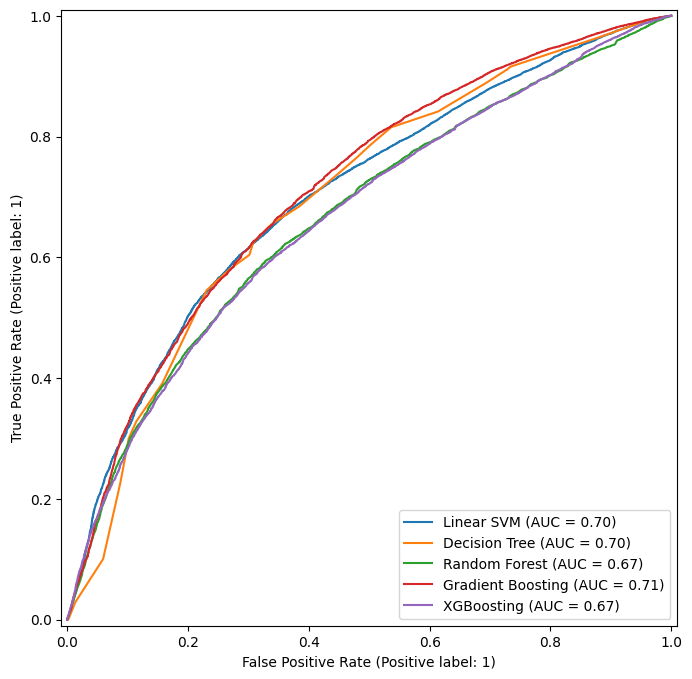

In [57]:
# xgboost weight
n_pos = sum(y_train == 1)
n_neg = sum(y_train == 0)
scale_pos_weight = n_neg / n_pos

# models
models = {
    "Linear SVM": LinearSVC(random_state=1312),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=1312),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=1312),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=1312),
    "XGBoosting": XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=1312, scale_pos_weight=scale_pos_weight)
}

all_results = []
plt.figure(figsize=(10, 8))  # ROC plot

# training
for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)

    # predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # prob or score 
    if hasattr(model, "predict_proba"):
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]
        response_method = "predict_proba"
    elif hasattr(model, "decision_function"):
        y_train_prob = model.decision_function(X_train)
        y_test_prob = model.decision_function(X_test)
        response_method = "decision_function"
    else:
        y_train_prob = None
        y_test_prob = None
        response_method = None

    # evaluate
    train_results = evaluate_model(y_train, y_train_pred, "Train", y_train_prob, model_name)
    test_results = evaluate_model(y_test, y_test_pred, "Test", y_test_prob, model_name)

    all_results.extend([train_results, test_results])

    # ROC
    if response_method is not None:
        RocCurveDisplay.from_estimator(
            model, X_test, y_test,
            name=model_name,
            response_method=response_method,
            ax=plt.gca()
        )
        
results_df = pd.DataFrame(all_results).set_index(["model", "dataset"])
print(results_df)

In [58]:
# considering the highest value of the ROC curve and the absence of significative overfitting, the best model on these training data is the Gradient Boosting 

### Second Training
### Train: from 11/2022 to 15/02/2023 & from 11/2023 to 15/02/2024, Test: from 11/2024 to 01/02/2025

In [59]:
# sort by prediction date
snapshots_final = snapshots_final.sort_values('prediction_date')

# train & test
train = snapshots_final[
    (snapshots_final['prediction_date'] == '2023-02-15 00:00:00') |
    (snapshots_final['prediction_date'] == '2024-02-15 00:00:00')
]
test = snapshots_final[snapshots_final['prediction_date'] == '2025-02-01 00:00:00']

X_train = train.drop(columns=['churn', 'prediction_date', 'user.uid', 'order.uid_nunique','zones'])
y_train = train['churn']

user_ids_test = test["user.uid"].copy()
X_test = test.drop(columns=['churn', 'prediction_date', 'user.uid', 'order.uid_nunique','zones'])
y_test = test['churn']

In [60]:
# checking proportions

def check_stratification(y_train, y_test):
    print("Train distribution:")
    print(y_train.value_counts(normalize=True).round(3), "\n")

    print("Test distribution:")
    print(y_test.value_counts(normalize=True).round(3), "\n")


check_stratification(y_train, y_test)
# highly imbalanced

Train distribution:
churn
1    0.798
0    0.202
Name: proportion, dtype: float64 

Test distribution:
churn
1    0.862
0    0.138
Name: proportion, dtype: float64 



### Comparison between algorithms


--- Training Linear SVM ---

--- Training Decision Tree ---

--- Training Random Forest ---

--- Training Gradient Boosting ---

--- Training XGBoosting ---
                           accuracy  precision    recall        f1   roc_auc
model             dataset                                                   
Linear SVM        Train    0.798361   0.798973  0.998456  0.887645  0.716683
                  Test     0.860419   0.861981  0.997781  0.924923  0.722031
Decision Tree     Train    0.614993   0.905073  0.578001  0.705471  0.730602
                  Test     0.599769   0.938334  0.573206  0.711669  0.723314
Random Forest     Train    0.941221   0.974455  0.951256  0.962715  0.983624
                  Test     0.845233   0.873497  0.959327  0.914403  0.671627
Gradient Boosting Train    0.809951   0.821428  0.973368  0.890967  0.761143
                  Test     0.853075   0.873618  0.969789  0.919195  0.747002
XGBoosting        Train    0.716003   0.917832  0.707320  0.798942  0.80

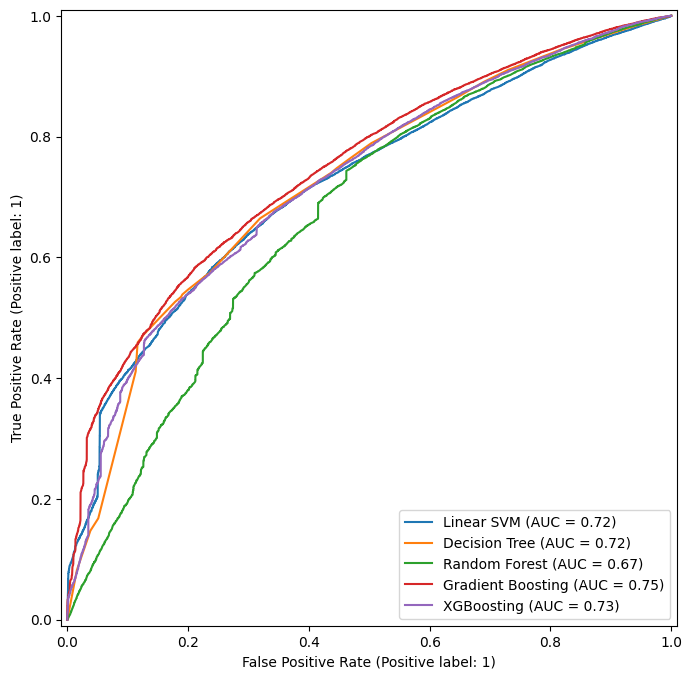

In [61]:
# xgboost weight
n_pos = sum(y_train == 1)
n_neg = sum(y_train == 0)
scale_pos_weight = n_neg / n_pos

# models
models = {
    "Linear SVM": LinearSVC(random_state=1312),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=1312),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=1312),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=1312),
    "XGBoosting": XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=1312, scale_pos_weight=scale_pos_weight)
}

all_results = []
plt.figure(figsize=(10, 8))  # ROC plot

# training
for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)

    # predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # prob or score 
    if hasattr(model, "predict_proba"):
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]
        response_method = "predict_proba"
    elif hasattr(model, "decision_function"):
        y_train_prob = model.decision_function(X_train)
        y_test_prob = model.decision_function(X_test)
        response_method = "decision_function"
    else:
        y_train_prob = None
        y_test_prob = None
        response_method = None

    # evaluate
    train_results = evaluate_model(y_train, y_train_pred, "Train", y_train_prob, model_name)
    test_results = evaluate_model(y_test, y_test_pred, "Test", y_test_prob, model_name)

    all_results.extend([train_results, test_results])

    # ROC
    if response_method is not None:
        RocCurveDisplay.from_estimator(
            model, X_test, y_test,
            name=model_name,
            response_method=response_method,
            ax=plt.gca()
        )
        
results_df = pd.DataFrame(all_results).set_index(["model", "dataset"])
print(results_df)

In [62]:
# considering the highest value of the ROC curve and the absence of significative overfitting, we select Gradient Boosting as our best model
best_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=1312)

### predictions_df: users with at least an order from 11/2024 to 01/02/2025

In [63]:
# fit
best_model.fit(X_train, y_train)  

# predictions
y_pred = best_model.predict(X_test)  
y_proba = best_model.predict_proba(X_test)[:, 1]

# to df
predictions_df = pd.DataFrame({
    "user.uid": user_ids_test,
    "will_be_churn?": y_pred,
    "churn_prob": y_proba,
    "churn_ground_truth": y_test.values
})

In [64]:
predictions_df.head()

,user.uid,will_be_churn?,churn_prob,churn_ground_truth
102298,03urulnlfgxxywsezqdqtbanda,1,0.527742,1
102244,00c2zutvhrg2wsots6dqti4acu,1,0.778266,1
102245,00clfrqurmcwn0xdlnqcpricmi,1,0.825310,1
102265,01drlhcnqkn74dsrybhqbk4nf9,1,0.862740,0
102247,00dija3tzdwkjxszdmgnqjtd8t,1,0.942434,1


In [65]:
predictions_df.shape

(62229, 4)

In [66]:
predictions_df[predictions_df['will_be_churn?']==1]

,user.uid,will_be_churn?,churn_prob,churn_ground_truth
102298,03urulnlfgxxywsezqdqtbanda,1,0.527742,1
102244,00c2zutvhrg2wsots6dqti4acu,1,0.778266,1
102245,00clfrqurmcwn0xdlnqcpricmi,1,0.825310,1
102265,01drlhcnqkn74dsrybhqbk4nf9,1,0.862740,0
102247,00dija3tzdwkjxszdmgnqjtd8t,1,0.942434,1
...,...,...,...,...
167272,zzqhupyucqrhts418vunjgdtea,1,0.933377,1
167257,zzikpntzfaqfnpsrzfn54bvqlv,1,0.621550,1
167256,zzikkchngfaux1zaferpzkwuxa,1,0.741478,1
167259,zzjxvf6khrarnli4gfbumwl2lm,1,0.862738,0


In [67]:
# project directory
from pathlib import Path
project_dir = Path.cwd().parents[0]
project_dir

WindowsPath('c:/Users/davyt/Desktop/Bicocca/Marketing Analytics/unimib_snowit_project')

In [68]:
# 'models' folder
models_dir = project_dir / "models"
models_dir.mkdir(parents=True, exist_ok=True) 
models_dir

WindowsPath('c:/Users/davyt/Desktop/Bicocca/Marketing Analytics/unimib_snowit_project/models')

In [69]:
# saving
predictions_df.to_csv(models_dir / "predicted_2024-2025_within_churn_df.csv", index=False)

### Final Training
### Train: all available data

In [70]:
# there is no labelled test set, this trained model could be used in the first half of 2025/2026 season to predict possible churners in the second part of that season

In [71]:
# sort by prediction date
snapshots_final = snapshots_final.sort_values('prediction_date')

# train
train = snapshots_final

X_train = train.drop(columns=['churn', 'prediction_date', 'user.uid', 'order.uid_nunique','zones'])
y_train = train['churn']

In [72]:
# checking proportions

def check_stratification_train(y_train):
    print("Train distribution:")
    print(y_train.value_counts(normalize=True).round(3), "\n")

check_stratification_train(y_train)
# highly imbalanced

Train distribution:
churn
1    0.822
0    0.178
Name: proportion, dtype: float64 



In [73]:
# we can just observe its training behaviour


--- Training Gradient Boosting ---
                           accuracy  precision    recall        f1   roc_auc
model             dataset                                                   
Gradient Boosting Train    0.829163   0.836072  0.985465  0.904642  0.763714


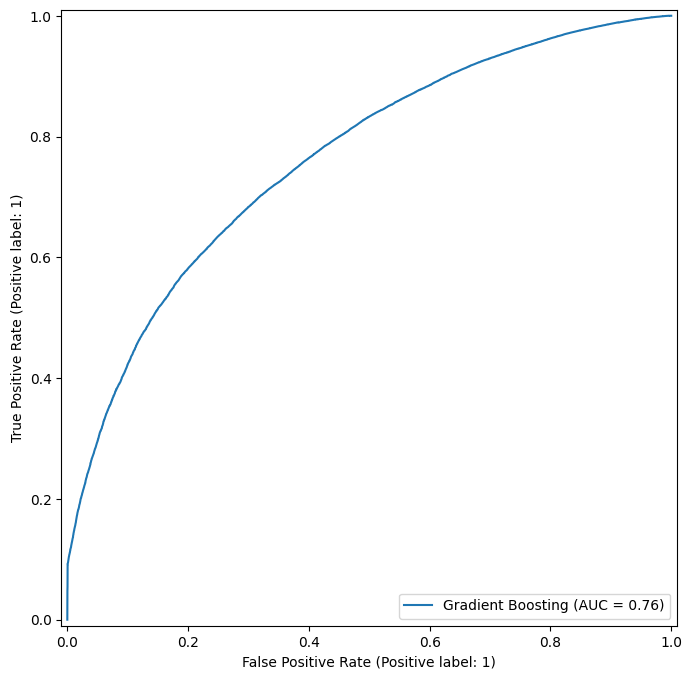

In [74]:
# models
models = {"Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=1312)}

all_results = []
plt.figure(figsize=(10, 8))  # ROC plot

# training
for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)

    # predictions
    y_train_pred = model.predict(X_train)

    # prob or score 
    if hasattr(model, "predict_proba"):
        y_train_prob = model.predict_proba(X_train)[:, 1]
        response_method = "predict_proba"
    elif hasattr(model, "decision_function"):
        y_train_prob = model.decision_function(X_train)
        response_method = "decision_function"
    else:
        y_train_prob = None
        response_method = None

    # evaluate
    train_results = evaluate_model(y_train, y_train_pred, "Train", y_train_prob, model_name)

    all_results.extend([train_results])

    # ROC
    if response_method is not None:
        RocCurveDisplay.from_estimator(
            model, X_train, y_train,
            name=model_name,
            response_method=response_method,
            ax=plt.gca()
        )
        
results_df = pd.DataFrame(all_results).set_index(["model", "dataset"])
print(results_df)